Erkennung von Distribution Shifts mithilfe des Kolmogorov-Smirnov-Test 

Connection: Week 0 to Week 1, p-value: 0.0119


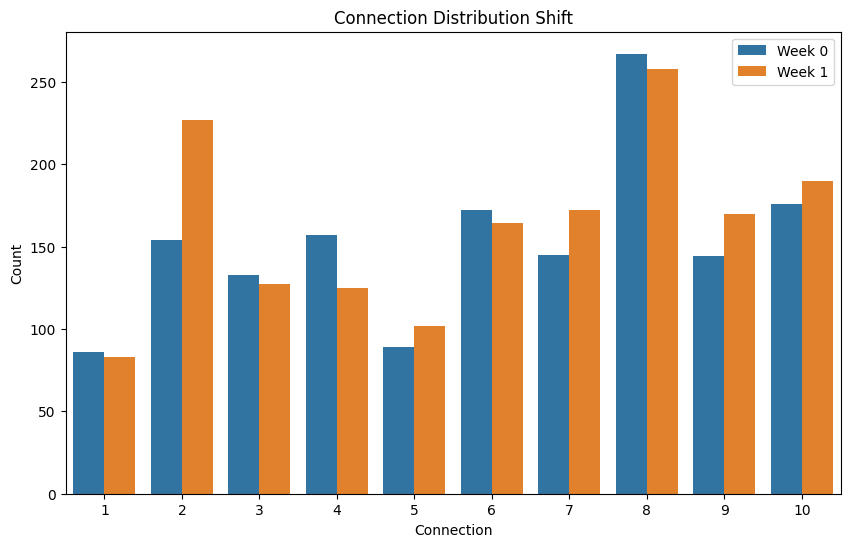

Connection: Week 1 to Week 2, p-value: 0.0183


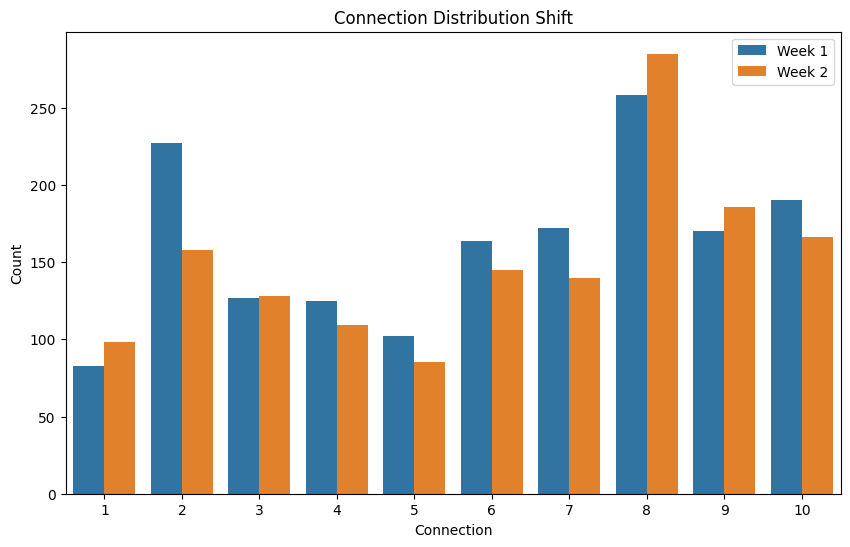

Connection: Week 2 to Week 3, p-value: 0.0426


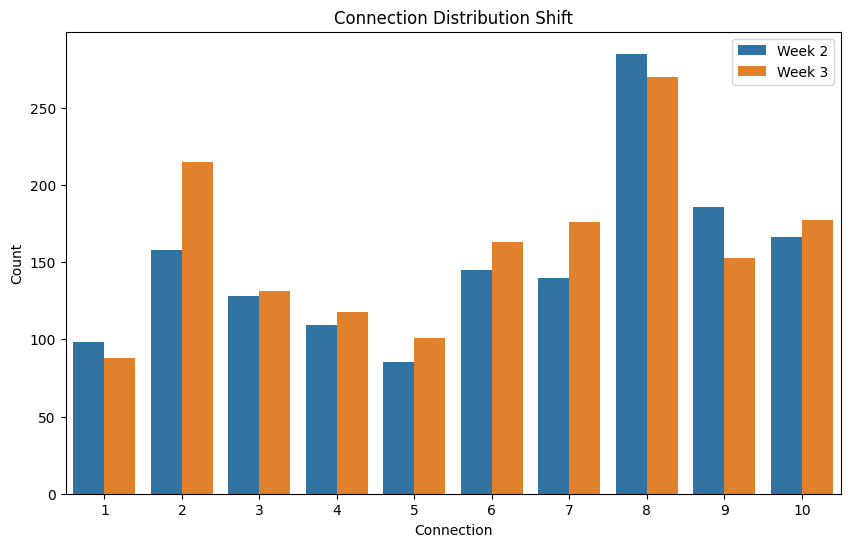

Unit_type: Week 0 to Week 1, p-value: 0.0036


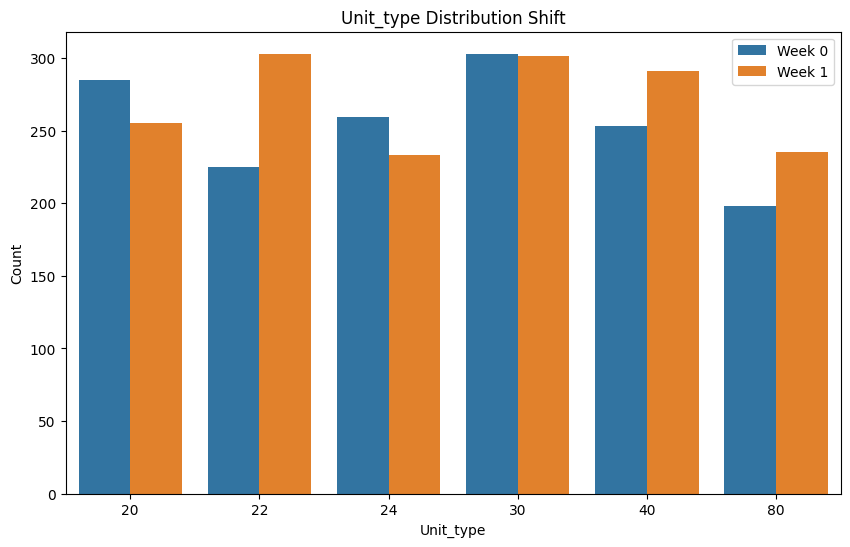

Unit_type: Week 1 to Week 2, p-value: 0.0068


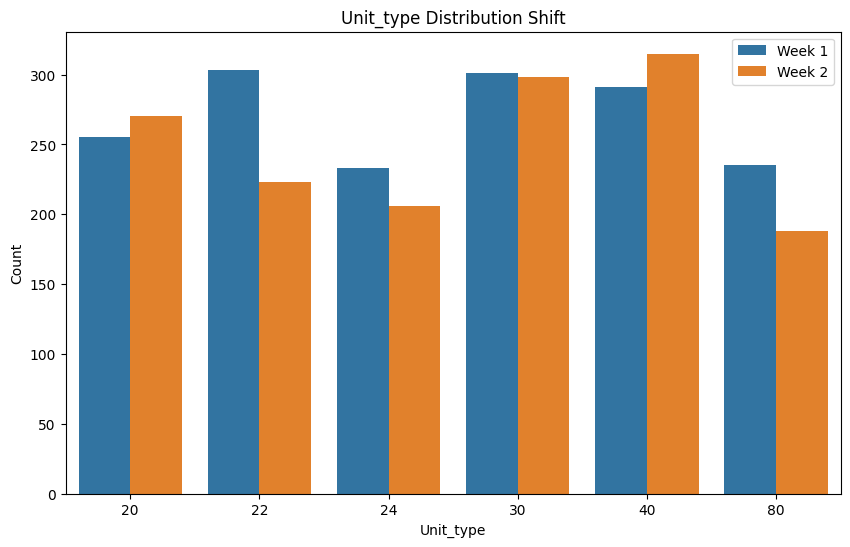

Unit_type: Week 2 to Week 3, p-value: 0.0076


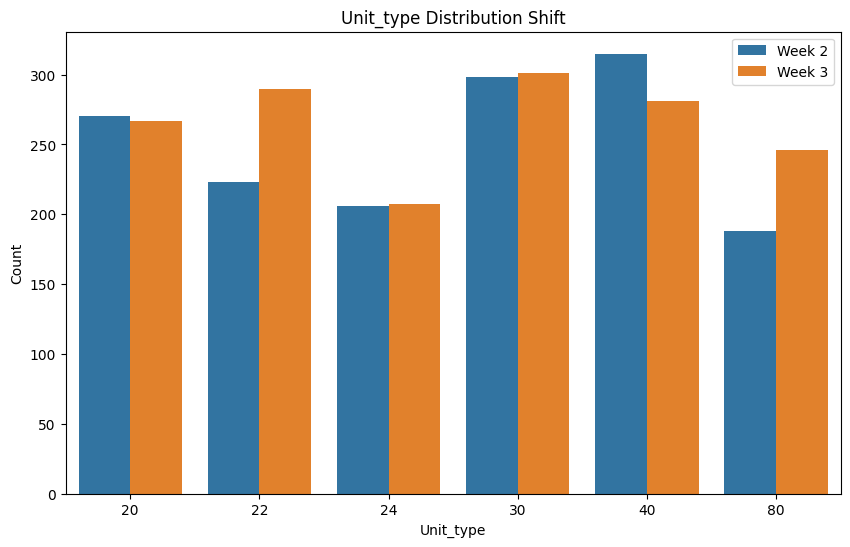

Unit_type: Week 3 to Week 4, p-value: 0.0223


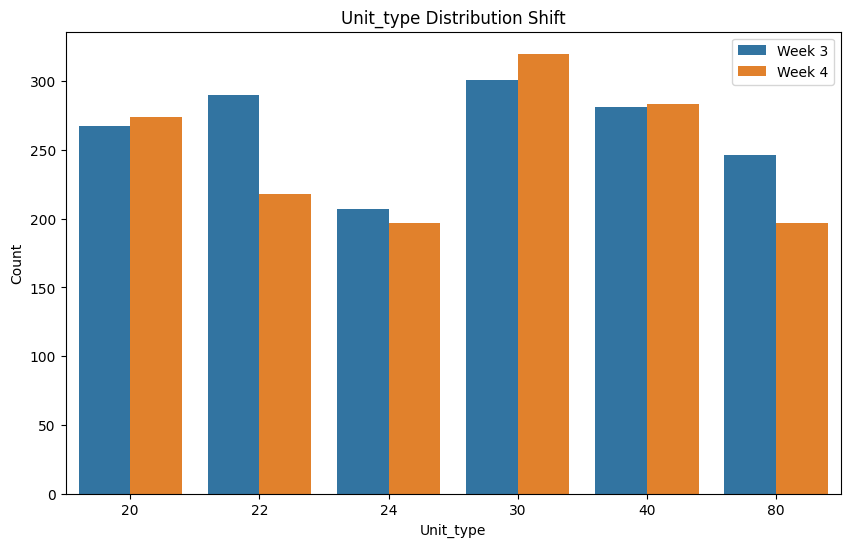

,Feature,Week_Start,Week_End,p_value
0,Connection,0,1,0.011902
1,Connection,1,2,0.018251
2,Connection,2,3,0.042561
3,Unit_type,0,1,0.003599
4,Unit_type,1,2,0.006840
5,Unit_type,2,3,0.007589
6,Unit_type,3,4,0.022258


In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = './test_daten.csv'  # Adjust this path to your CSV file location
data = pd.read_csv(file_path)

# Function to detect distribution shift for continuous variable using KS test
def detect_continuous_shifts(data, feature, alpha=0.05):
    weeks = sorted(data['Week'].unique())
    significant_shifts = []
    
    for i in range(1, len(weeks)):
        week_1 = data[data['Week'] == weeks[i-1]][feature]
        week_2 = data[data['Week'] == weeks[i]][feature]
        
        # Perform KS test
        if not week_1.empty and not week_2.empty:
            ks_stat, p_value = ks_2samp(week_1, week_2)
            
            # Check if the shift is significant
            if p_value < alpha:
                significant_shifts.append((feature, weeks[i-1], weeks[i], p_value))
    
    return significant_shifts

# Function to detect significant differences for discrete variables using Chi-Square test
def detect_discrete_shifts(data, feature, alpha=0.05):
    weeks = sorted(data['Week'].unique())
    significant_shifts = []
    
    for i in range(1, len(weeks)):
        week_1 = data[data['Week'] == weeks[i-1]][feature].value_counts()
        week_2 = data[data['Week'] == weeks[i]][feature].value_counts()
        
        # Align the series to ensure they have the same categories
        week_1, week_2 = week_1.align(week_2, fill_value=0)
        
        # Create a contingency table
        contingency_table = pd.DataFrame([week_1, week_2])
        
        # Perform Chi-Square test
        chi2_stat, p_value, dof, ex = chi2_contingency(contingency_table)
        
        # Check if the difference is significant
        if p_value < alpha:
            significant_shifts.append((feature, weeks[i-1], weeks[i], p_value))
    
    return significant_shifts

# Detect shifts for each feature
features_continuous = ['Weight']
features_discrete = ['Connection', 'Unit_type']
all_significant_shifts = []

for feature in features_continuous:
    shifts = detect_continuous_shifts(data, feature)
    all_significant_shifts.extend(shifts)
for feature in features_discrete:
    shifts = detect_discrete_shifts(data, feature)
    all_significant_shifts.extend(shifts)

# Create a DataFrame for significant shifts
columns = ['Feature', 'Week_Start', 'Week_End', 'p_value']
significant_shifts_df = pd.DataFrame(all_significant_shifts, columns=columns)

# Output the significant shifts and visualize
for feature in significant_shifts_df['Feature'].unique():
    feature_shifts = significant_shifts_df[significant_shifts_df['Feature'] == feature]
    for _, row in feature_shifts.iterrows():
        week_start = row['Week_Start']
        week_end = row['Week_End']
        p_value = row['p_value']
        
        print(f"{feature}: Week {week_start} to Week {week_end}, p-value: {p_value:.4f}")
        
        # Visualize the shifts
        week_1_data = data[data['Week'] == week_start][feature]
        week_2_data = data[data['Week'] == week_end][feature]
        
        plt.figure(figsize=(10, 6))
        if feature in features_continuous:
            sns.histplot(week_1_data, color='blue', label=f'Week {week_start}', kde=True, stat="density")
            sns.histplot(week_2_data, color='red', label=f'Week {week_end}', kde=True, stat="density")
            plt.xlabel(feature)
        else:
            # Create DataFrame for plotting
            week_1_df = week_1_data.value_counts().reset_index()
            week_1_df.columns = [feature, 'Count']
            week_1_df['Week'] = f'Week {week_start}'
            
            week_2_df = week_2_data.value_counts().reset_index()
            week_2_df.columns = [feature, 'Count']
            week_2_df['Week'] = f'Week {week_end}'
            
            plot_df = pd.concat([week_1_df, week_2_df])
            
            sns.barplot(x=feature, y='Count', hue='Week', data=plot_df)
            plt.xlabel(feature)
            plt.ylabel('Count')
        
        plt.title(f'{feature} Distribution Shift')
        plt.ylabel('Density' if feature in features_continuous else 'Count')
        plt.legend()
        plt.show()

# Display the DataFrame with significant shifts
significant_shifts_df
